In [47]:
import numpy as np 
import astropy.units as u
from scipy.signal import medfilt
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter
# -- feasibgs --
from feasibgs import util as UT
from feasibgs import skymodel as Sky
# -- desi -- 
import desimodel.io
import desisim.simexp

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
# ccd wavelength limit 
params = desimodel.io.load_desiparams() 
wavemin = params['ccd']['b']['wavemin']
wavemax = params['ccd']['z']['wavemax']
print('%f < lambda < %f' % (wavemin, wavemax))

waves = np.linspace(wavemin, wavemax, 1e4) * u.angstrom
config = desisim.simexp._specsim_config_for_wave((waves).to('Angstrom').value, specsim_config_file='desi')

surface_brightness_dict = config.load_table(config.atmosphere.sky, 'surface_brightness', as_dict=True)

3533.000000 < lambda < 9913.000000


/Users/chang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.
  import sys


In [59]:
uves = np.loadtxt('/Volumes/chang_eHDD/projects/desi/data/spectra/spec-sky.dat', skiprows=2)

In [63]:
print config.wavelength.value[::10]
print surface_brightness_dict['dark'].value[::10]

[3533.   3539.38 3545.76 ... 9900.24 9906.62 9913.  ]
[1.5517   1.3961   2.35884  ... 0.919214 0.798608 0.84125 ]


In [66]:
(config.wavelength.value[1:] - config.wavelength.value[:-1]).min()

0.6379999999990105

In [67]:
print uves[1:,0]-uves[:-1,0]

[0.1 0.1 0.1 ... 0.1 0.1 0.1]


In [65]:
print uves[::10,1]

[1.6266  3.169   1.4083  ... 0.80043 0.93008 1.4289 ]


(0.0, 10.0)

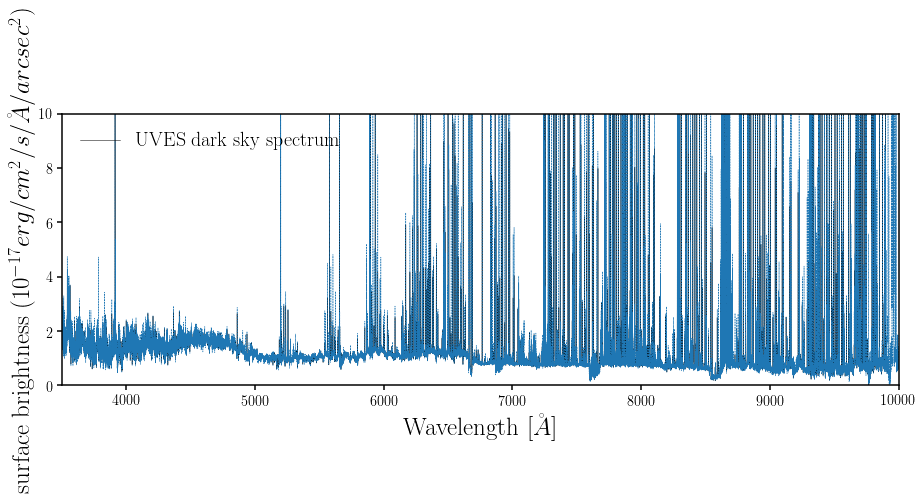

In [69]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.plot(config.wavelength, surface_brightness_dict['dark'].value, c='k', lw=0.5, label='UVES dark sky spectrum')
sub.plot(uves[:,0], uves[:,1], lw=0.5, ls='--')
sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel(r'Wavelength [$\AA$]', fontsize=25)
sub.set_xlim([3500., 1.e4])
sub.set_ylabel(r"surface brightness ($10^{-17} erg/cm^{2}/s/\AA/arcsec^2$)", fontsize=25)
sub.set_ylim([0., 10.])

In [70]:
wls, emfluxes = [], [] 
for n in ['346', '437', '580L', '580U', '800U', '860L', '860U']: 
    f = ''.join([UT.code_dir(), 'dat/sky/UVES_ident/', 'gident_', n, '.dat'])
    wl, emfwhm, emflux = np.loadtxt(open(f, 'rt').readlines()[:-1], skiprows=3, unpack=True, usecols=[1, 3, 4])
    wls.append(wl)
    emfluxes.append(emflux)
wls = np.concatenate(wls)
emfluxes = np.concatenate(emfluxes)

In [71]:
def n_edlen(ll): 
    return 1. + 10**-8 * (8432.13 + 2406030./(130.-(1/ll)**2) + 15977/(38.9 - (1/ll)**2))

(0.0, 10.0)

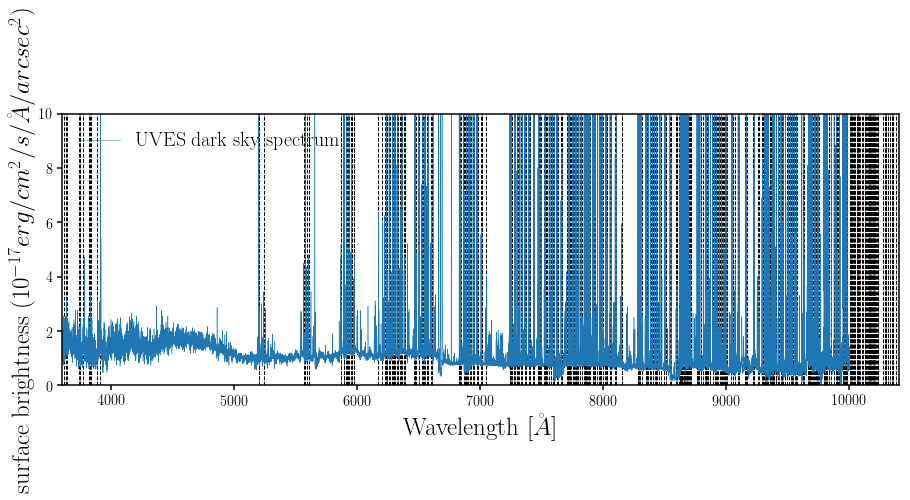

In [72]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.plot(uves[:,0], uves[:,1], c='C0', lw=0.5, label='UVES dark sky spectrum')

keep = (emfluxes > 0.5) & (wls >= 3600.) & (wls <= 10400.)
for w in wls[keep]: 
    sub.vlines(w * n_edlen(w/1e4), 0., 10., color='k', linestyle='--', linewidth=1)
sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel(r'Wavelength [$\AA$]', fontsize=25)
sub.set_xlim([3600., 10400])
sub.set_ylabel(r"surface brightness ($10^{-17} erg/cm^{2}/s/\AA/arcsec^2$)", fontsize=25)
sub.set_ylim([0., 10.])

(0.0, 10.0)

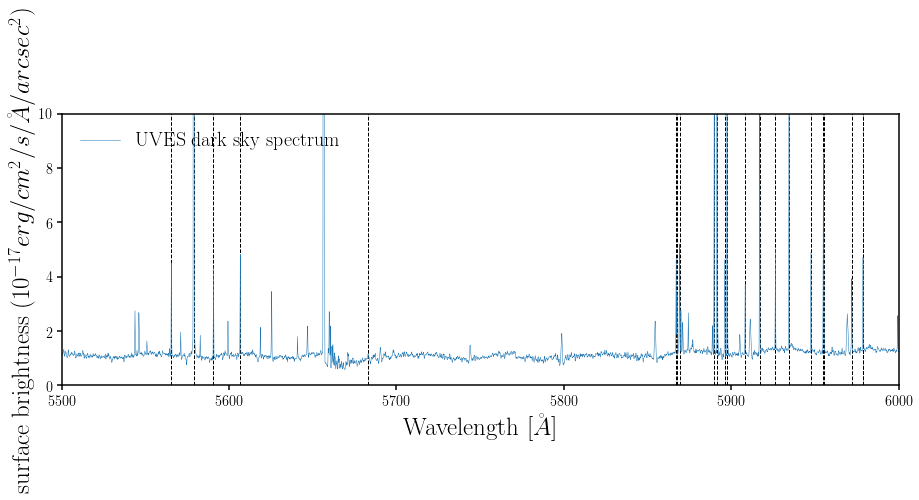

In [73]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
#sub.plot(config.wavelength, surface_brightness_dict['dark'].value, c='C0', lw=0.5, label='UVES dark sky spectrum')
sub.plot(uves[:,0], uves[:,1], c='C0', lw=0.5, label='UVES dark sky spectrum')
for w in wls[keep]: 
    sub.vlines(w * n_edlen(w/1e4), 0., 10., color='k', linestyle='--', linewidth=1)
sub.vlines(5683, 0., 10., color='k', linestyle='--', linewidth=1)
sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel(r'Wavelength [$\AA$]', fontsize=25)
#sub.set_xlim([5150., 5300])
sub.set_xlim([5500., 6000])
sub.set_ylabel(r"surface brightness ($10^{-17} erg/cm^{2}/s/\AA/arcsec^2$)", fontsize=25)
sub.set_ylim([0., 10.])

In [74]:
wave = uves[:,0] #config.wavelength.value
lines_mask = np.ones(len(wave)).astype(bool)
for w in wls[keep]: 
    nearline = ((wave > w * n_edlen(w) - 5.) & (wave < w * n_edlen(w) + 5.))
    lines_mask = lines_mask & ~nearline
    
lamp = np.array([4047, 4048, 4165, 4168, 4358, 4420, 4423, 4665, 4669, 4827, 
                 4832, 4983, 5461, 5683, 5688, 5770, 5791, 5893, 6154, 6161]) 
for w in lamp: 
    nearline = ((wave > w - 5) & (wave < w + 5.))
    lines_mask = lines_mask & ~nearline

(0.0, 10.0)

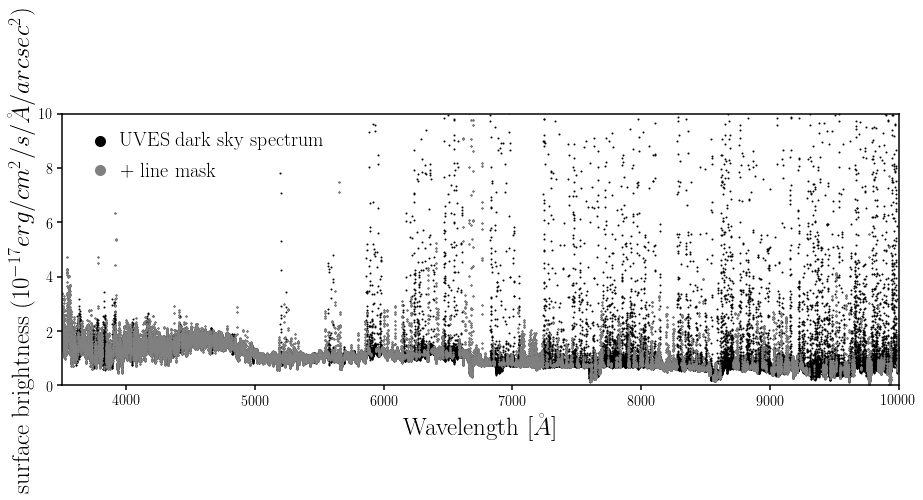

In [77]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.scatter(wave, uves[:,1], 
         c='k', s=1, label='UVES dark sky spectrum')
sub.scatter(wave[lines_mask], uves[:,1][lines_mask], 
         c='gray', s=1, label='+ line mask')
sub.legend(loc='upper left', markerscale=10, handletextpad=0., fontsize=20)
sub.set_xlabel(r'Wavelength [$\AA$]', fontsize=25)
sub.set_xlim([3500., 1.e4])
sub.set_ylabel(r"surface brightness ($10^{-17} erg/cm^{2}/s/\AA/arcsec^2$)", fontsize=25)
sub.set_ylim([0., 10.])

(0.0, 10.0)

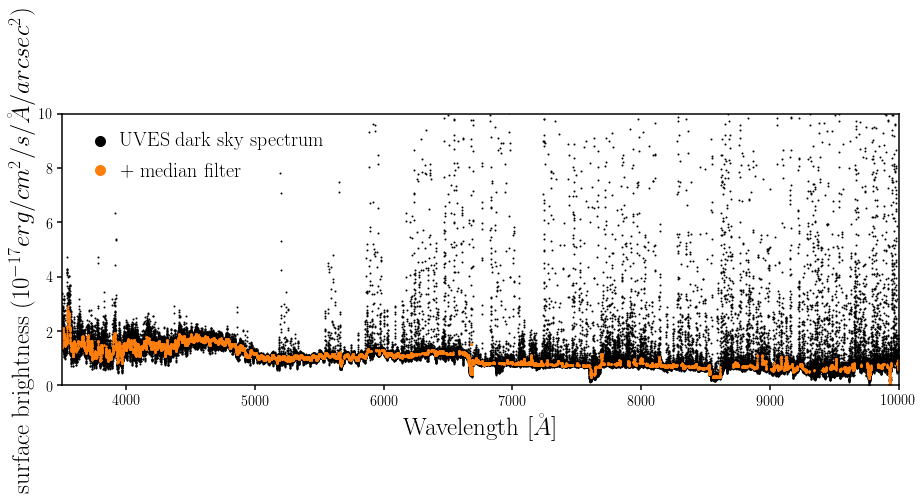

In [91]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.scatter(wave, uves[:,1], 
         c='k', s=1, label='UVES dark sky spectrum')
#sub.scatter(wave[lines_mask], uves[:,1][lines_mask], 
#         c='gray', s=1, label='+ line mask')
sky_filtered = medfilt(uves[:,1][lines_mask], 51)
sub.scatter(wave[lines_mask], sky_filtered, 
         c='C1', s=1, label='+ median filter')
sub.legend(loc='upper left', markerscale=10, handletextpad=0., fontsize=20)
sub.set_xlabel(r'Wavelength [$\AA$]', fontsize=25)
sub.set_xlim([3500., 1.e4])
sub.set_ylabel(r"surface brightness ($10^{-17} erg/cm^{2}/s/\AA/arcsec^2$)", fontsize=25)
sub.set_ylim([0., 10.])

(0.0, 10.0)

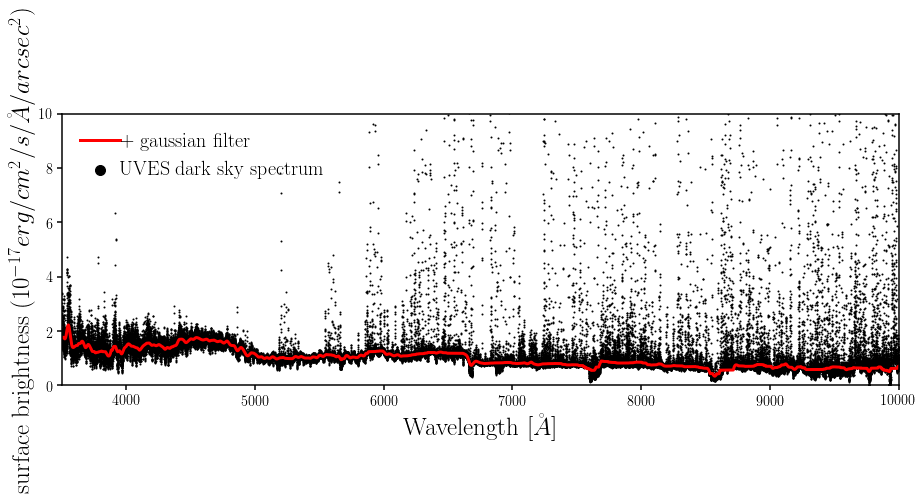

In [93]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.scatter(wave, uves[:,1], 
         c='k', s=1, label='UVES dark sky spectrum')
#sub.scatter(wave[lines_mask], uves[:,1][lines_mask], 
#         c='gray', s=1, label='+ line mask')
sub.plot(wave[lines_mask], gaussian_filter(sky_filtered, 100), 
           c= 'r', lw=3, label='+ gaussian filter')
sub.legend(loc='upper left', markerscale=10, handletextpad=0., fontsize=20)
sub.set_xlabel(r'Wavelength [$\AA$]', fontsize=25)
sub.set_xlim([3500., 1.e4])
sub.set_ylabel(r"surface brightness ($10^{-17} erg/cm^{2}/s/\AA/arcsec^2$)", fontsize=25)
sub.set_ylim([0., 10.])

(0.0, 10.0)

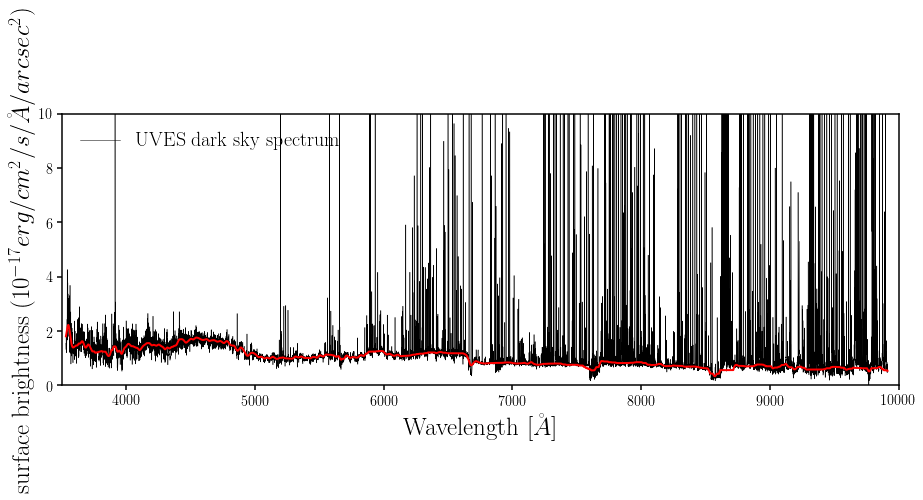

In [109]:
f_cont = interp1d(wave[lines_mask], gaussian_filter(sky_filtered, 100), bounds_error=False, fill_value='extrapolate')

fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.plot(config.wavelength, surface_brightness_dict['dark'].value, c='k', lw=0.5, label='UVES dark sky spectrum')
sub.plot(config.wavelength, f_cont(config.wavelength.value), c='r', lw=2)
sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel(r'Wavelength [$\AA$]', fontsize=25)
sub.set_xlim([3500., 1.e4])
sub.set_ylabel(r"surface brightness ($10^{-17} erg/cm^{2}/s/\AA/arcsec^2$)", fontsize=25)
sub.set_ylim([0., 10.])

(-0.5, 10.0)

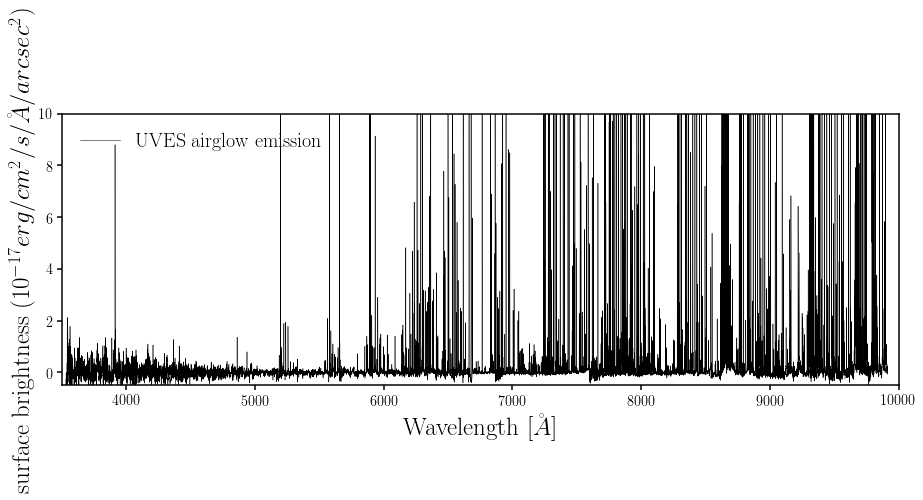

In [110]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.plot(config.wavelength, surface_brightness_dict['dark'].value - f_cont(config.wavelength.value), 
         c='k', lw=0.5, label='UVES airglow emission')
sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel(r'Wavelength [$\AA$]', fontsize=25)
sub.set_xlim([3500., 1.e4])
sub.set_ylabel(r"surface brightness ($10^{-17} erg/cm^{2}/s/\AA/arcsec^2$)", fontsize=25)
sub.set_ylim([-0.5, 10.])

In [108]:
print wave.min(), wave.max()
print wave[lines_mask].min(), wave[lines_mask].max()

3500.0 9999.9
3500.0 9997.7


(-0.5, 10.0)

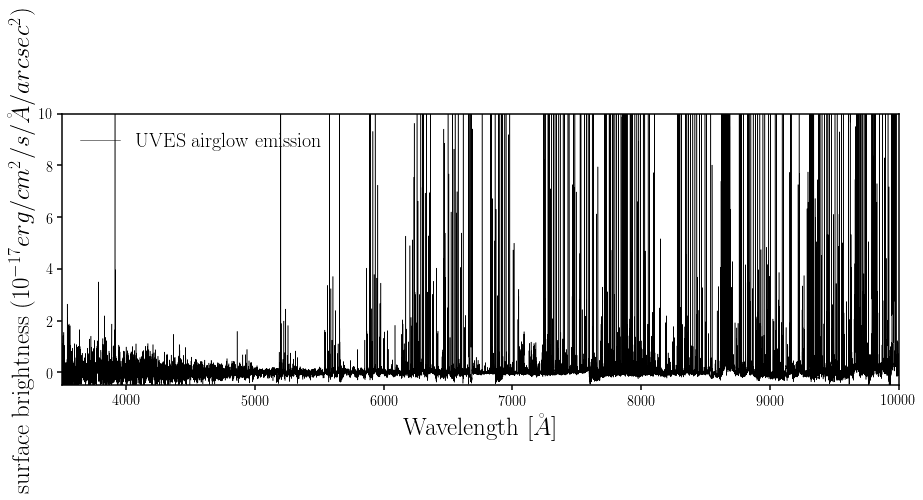

In [111]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
sub.plot(wave, uves[:,1] - f_cont(wave), 
         c='k', lw=0.5, label='UVES airglow emission')
sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel(r'Wavelength [$\AA$]', fontsize=25)
sub.set_xlim([3500., 1.e4])
sub.set_ylabel(r"surface brightness ($10^{-17} erg/cm^{2}/s/\AA/arcsec^2$)", fontsize=25)
sub.set_ylim([-0.5, 10.])